In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.fft import fft2, fftshift
import tqdm
from matplotlib.colors import LogNorm
import tools
import importlib
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interact

In [12]:
importlib.reload(tools)

<module 'tools' from '/Users/tillmoritz/Desktop/Studies/Master_Studies/Oceanic_proc_obs/Git/ocean_pro/tools.py'>

## Load the data using the videoloader

In [46]:
run_13_12_first = {"name":"blueskies",'path':"/Users/tillmoritz/Desktop/Studies/Master_Studies/Oceanic_proc_obs/13.12.-1.75-0.96.avi",'x_up':600,'x_down':1500,'y_left':0,'y_right':2500, 'window_size':40}
run_13_12_first_res = {'x_up':300,'x_down':500,'y_left':170,'y_right':350, 'window_size':40}

run_20_12_first = {'name':"laserballz",'path':"/Users/tillmoritz/Desktop/Studies/Master_Studies/Oceanic_proc_obs/20.12.-1.59-0.95.avi",'x_up':700,'x_down':1200,'y_left':0,'y_right':2500, 'window_size':40}
run_20_12_first_res = {'x_up':1660,'x_down':1820,'y_left':360,'y_right':540, 'window_size':40}

par = run_20_12_first_res
par_window = run_20_12_first

In [14]:
video_path = par_window['path']
video_loader = tools.AVIFileLoader(video_path)

### Find the grid in the frame to know size of pixel (resolution)

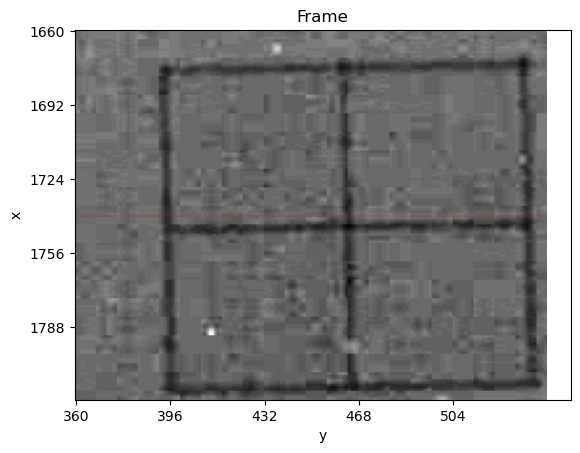

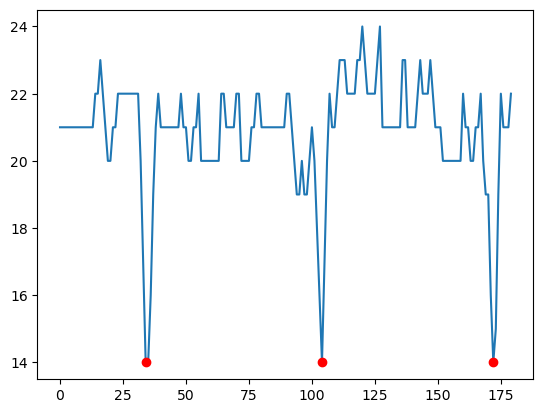

[70 68]
Pixel size in mm:  0.14492753623188406


In [15]:
index = 0
frame = video_loader.get_frame(index)
n_px = tools.find_gridsize(frame, x_up=par['x_up'],x_down=par['x_down'],y_left=par['y_left'],y_right=par['y_right'], window_size=par['window_size'])
pixel_size = 10/n_px
### print the pixel size in mm
print("Pixel size in mm: ", pixel_size)

### Find the window of the video that will be used to analyze the salt fingers

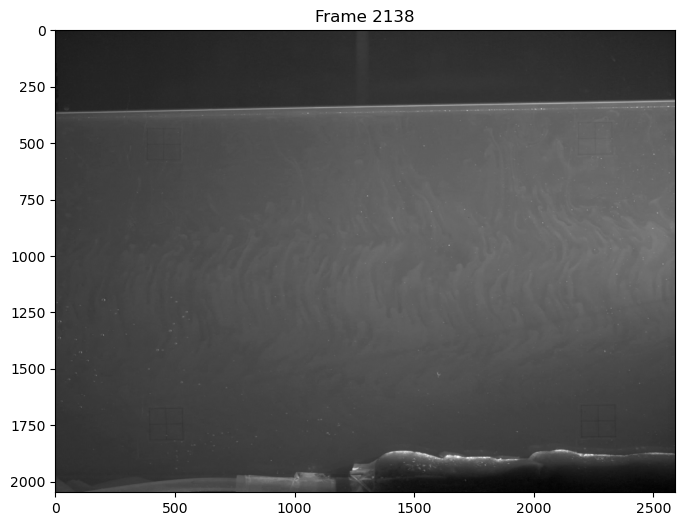

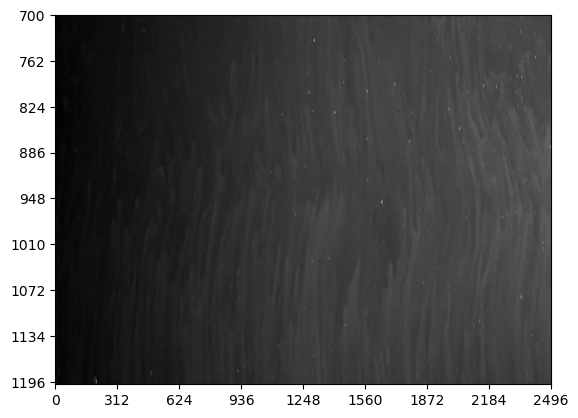

In [16]:
x_up, x_down, y_left, y_right = tools.find_size(video_loader, x_up=par_window['x_up'],x_down=par_window['x_down'],y_left=par_window['y_left'],y_right=par_window['y_right'],color_channel=1)

In [17]:
baseline_frame = tools.display_baseline_selector(video_loader=video_loader, par_window=par_window)

interactive(children=(IntSlider(value=0, description='Frame number:', max=500), IntSlider(value=0, description…

In [18]:
### calculate the baseline of the video
_,baseline= tools.fourier_analysis(video_loader,pixel_size, x_up=par_window['x_up'],x_down=par_window['x_down'],y_left=par_window['y_left'],y_right=par_window['y_right'],start_frame=baseline_frame['baseline'], end_frame=baseline_frame['baseline']+20,detrend=True)
for key in baseline.keys():
    normalized_baseline = [frame_magnitude / frame_magnitude.max() if frame_magnitude.max() != 0 else frame_magnitude for frame_magnitude in baseline[key]]
    baseline[key] = np.array([
            np.mean(normalized_baseline[i:i+1], axis=0) 
            for i in range(0, len(normalized_baseline), 1)
        ])
baseline_hor = np.mean(baseline['horizontal'], axis=0)
baseline_vert = np.mean(baseline['vertical'], axis=0)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [19]:
confirmed_frames = tools.interactive_start_end_selector(video_loader=video_loader, par_window=par_window)

interactive(children=(IntSlider(value=0, description='Start Frame:', max=4276), IntSlider(value=0, description…

Start frame confirmed: 0
End frame confirmed: 1000


Start frame confirmed: 655
End frame confirmed: 862


Start frame confirmed: 483
End frame confirmed: 2587


Processing frames:   0%|          | 0/2105 [00:00<?, ?it/s]

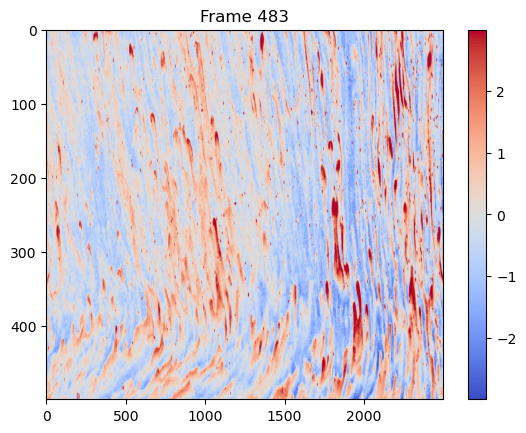

Processing frames: 100%|█████████▉| 2104/2105 [14:44<00:00,  2.44it/s]

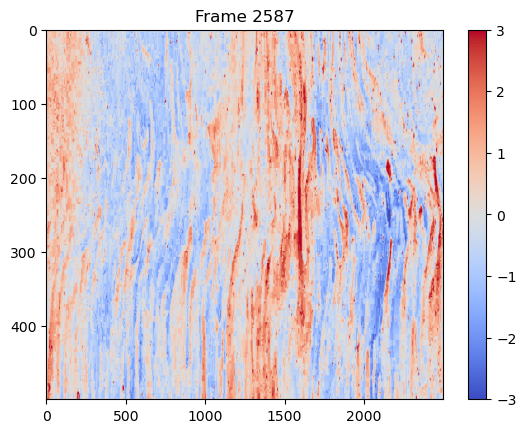

Processing frames: 100%|██████████| 2105/2105 [14:45<00:00,  2.38it/s]


In [28]:
wavenumbers, magnitudes= tools.fourier_analysis(video_loader,pixel_size, x_up=par_window['x_up'],x_down=par_window['x_down'],y_left=par_window['y_left'],y_right=par_window['y_right'],start_frame=confirmed_frames['start'], end_frame=confirmed_frames['end'],detrend=True)

In [48]:
#### save magnitude and wavenumbers
np.save('wavenumbers_'+par_window['name'],wavenumbers)
np.save('magnitudes_'+par_window['name'],magnitudes)

In [50]:
### load magnitude and wavenumbers
wavenumbers = np.load('wavenumbers_'+par_window['name']+".npy", allow_pickle=True).item()
magnitudes = np.load('magnitudes_'+par_window['name']+".npy", allow_pickle=True).item()


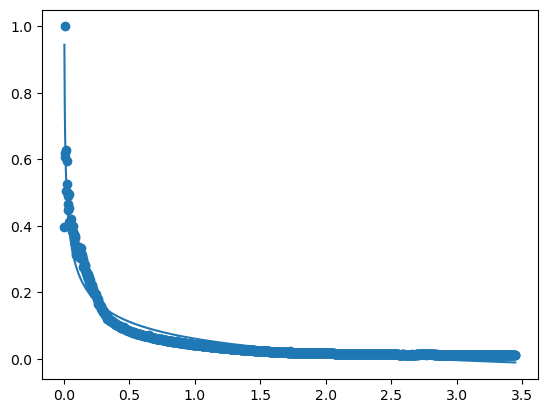

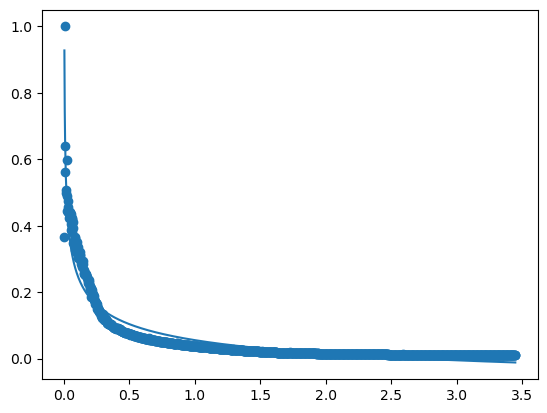

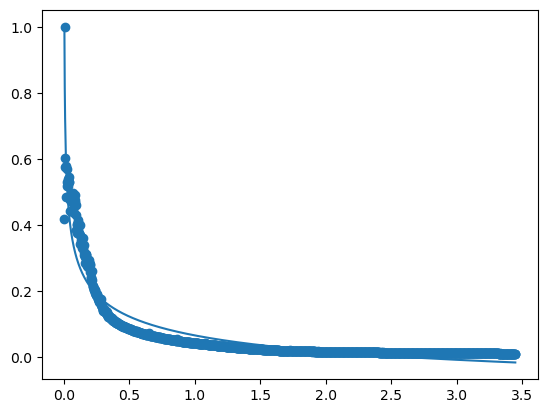

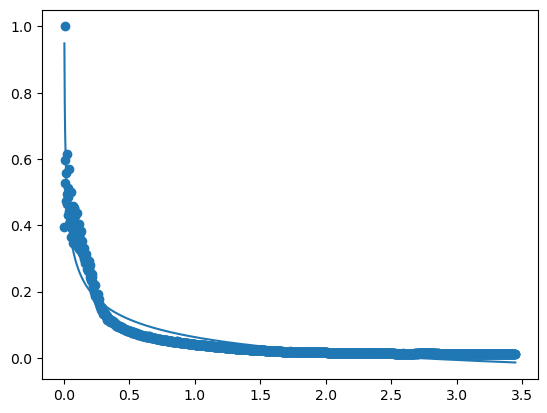

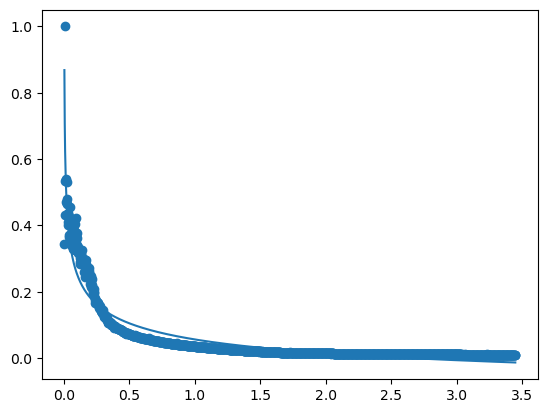

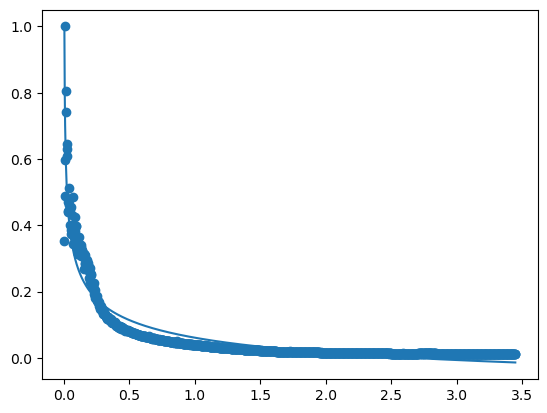

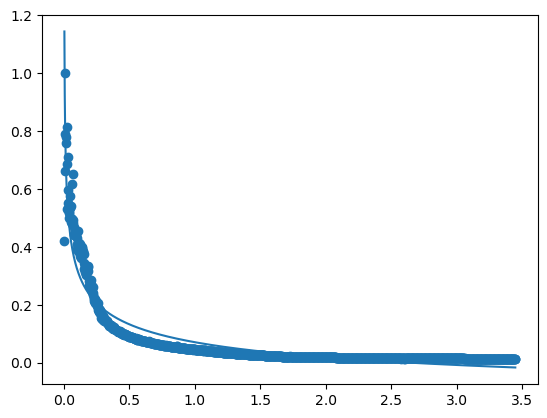

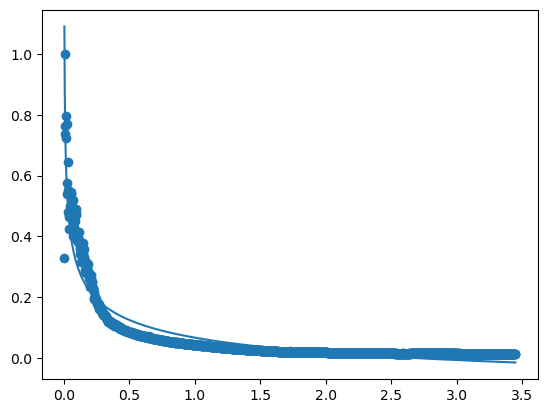

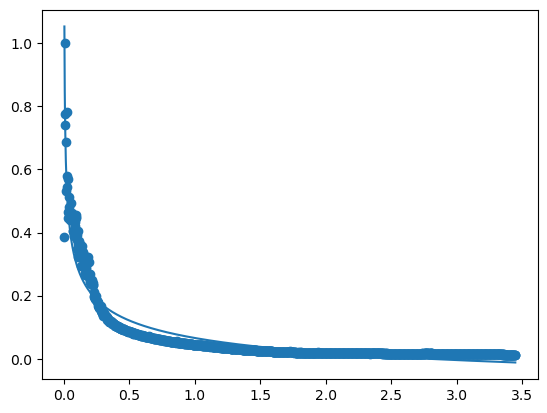

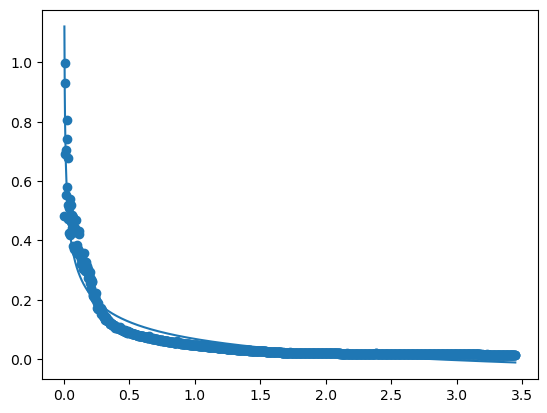

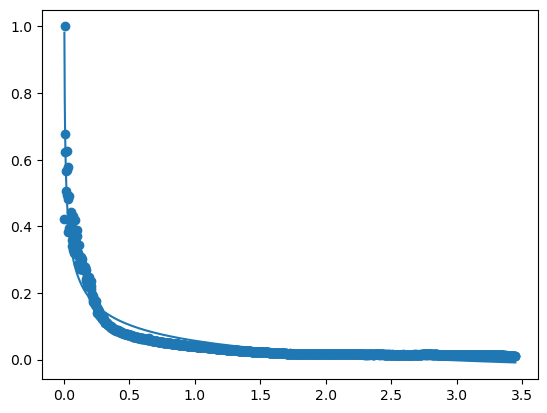

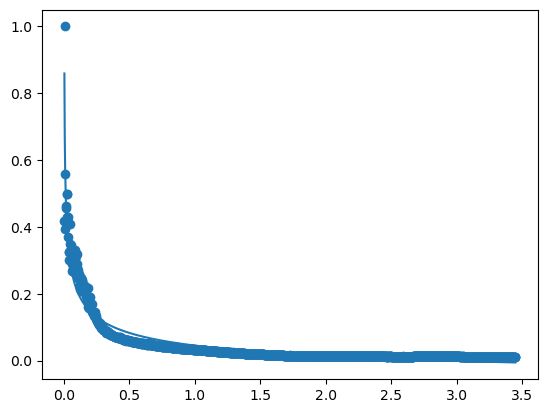

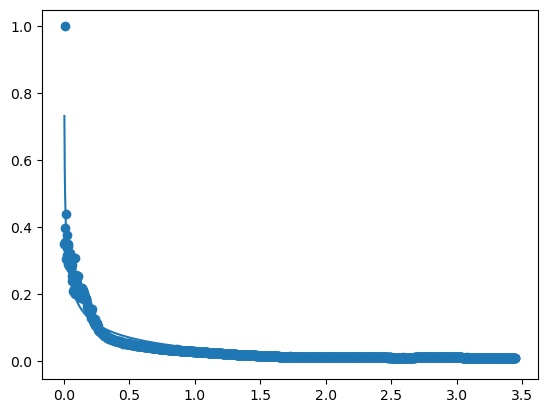

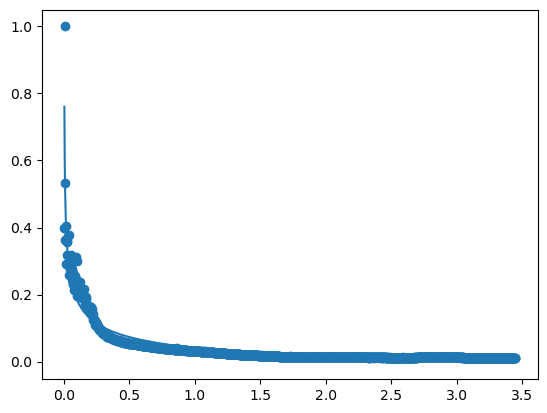

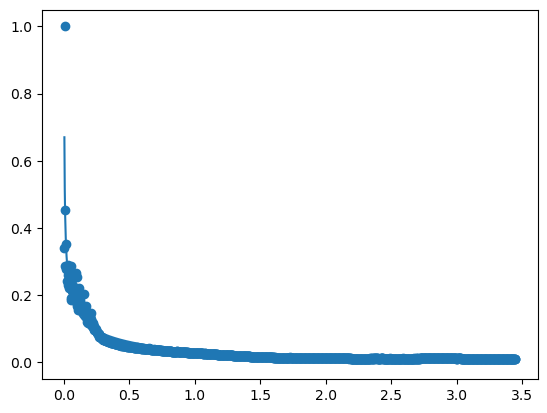

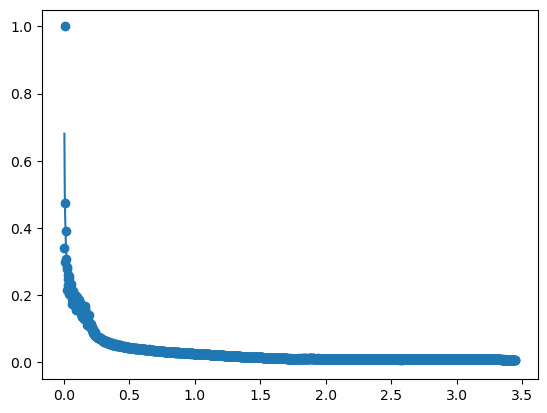

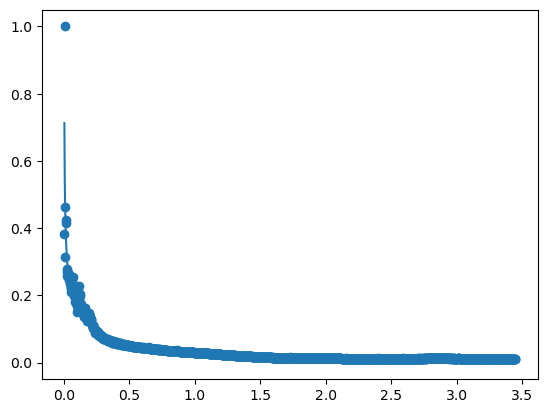

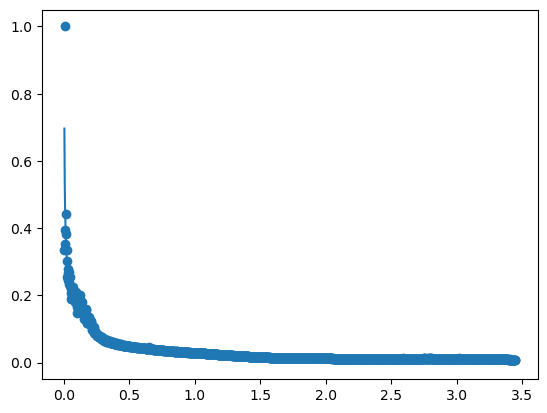

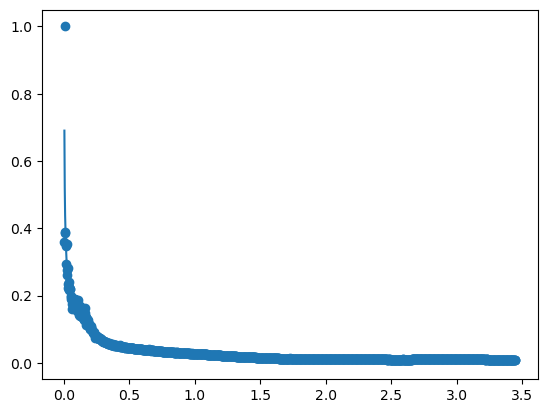

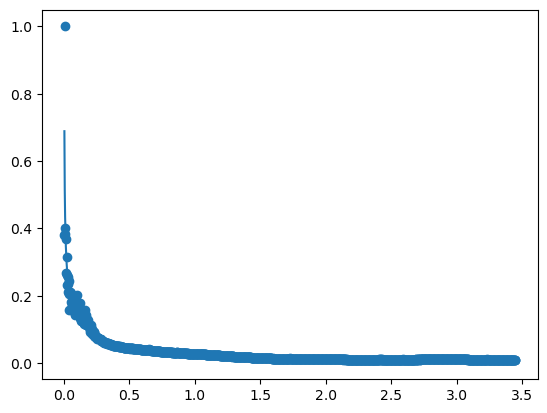

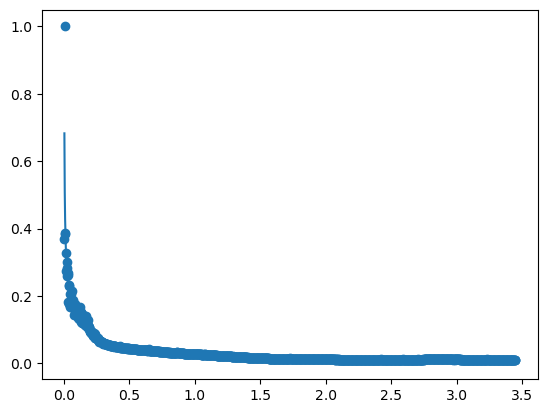

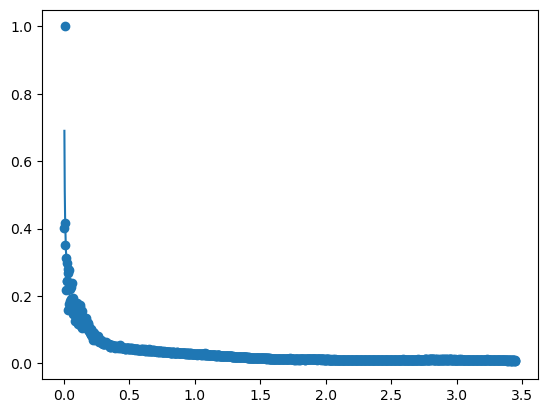

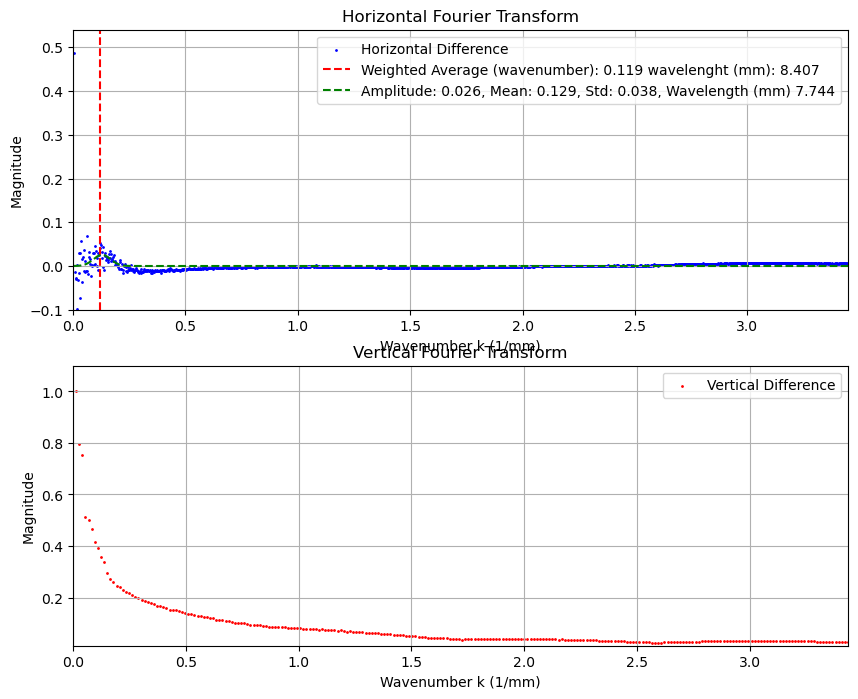

In [52]:
importlib.reload(tools)
animation = tools.fourier_animation(wavenumbers, magnitudes,baseline_horizontal=0,baseline_vertical=0, average=100,fit_min=0.05,fit_max=0.3,n_max_mag=20)
HTML(animation.to_jshtml())
### save the animation
animation.save(f'animation_{par_window['name']}.mp4', writer='ffmpeg', fps=2)

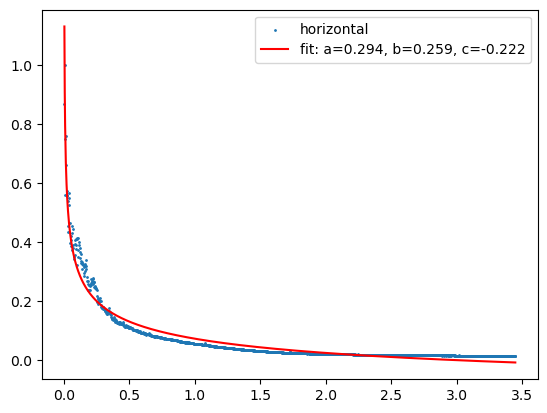

In [22]:
plt.scatter(wavenumbers['horizontal'][0], baseline_hor, label='horizontal',s=1)
# fit 1/x function to the data with curve_fit
def func(x, a, b, c):
    return a/(x**b) + c

from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, wavenumbers['horizontal'][0], baseline_hor)
plt.plot(wavenumbers['horizontal'][0], func(wavenumbers['horizontal'][0], *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.legend()
#plt.yscale('log')